# Final Project

---
Please edit the cell below to include your name and student ID #

**name: Muhammad Albayati**

**SID: 84652863**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import meshutils
import camutils import
import pickle
import visutils
import selectpoints
import calibrate
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import scipy.spatial
%matplotlib notebook

In [ ]:
def decode(imprefix,start,threshold):
    """
    Given a sequence of 20 images of a scene showing projected 10 bit gray code, 
    decode the binary sequence into a decimal value in (0,1023) for each pixel.
    Mark those pixels whose code is likely to be incorrect based on the user 
    provided threshold.  Images are assumed to be named "imageprefixN.png" where
    N is a 2 digit index (e.g., "img00.png,img01.png,img02.png...")
 
    Parameters
    ----------
    imprefix : str
       Image name prefix
      
    start : int
       Starting index
       
    threshold : float
       Threshold to determine if a bit is decodeable
       
    Returns
    -------
    code : 2D numpy.array (dtype=float)
        Array the same size as input images with entries in (0..1023)
        
    mask : 2D numpy.array (dtype=logical)
        Array indicating which pixels were correctly decoded based on the threshold
    
    """
    
    # we will assume a 10 bit code
    nbits = 10
    images = [None] * 10
    inv_images = [None] * 10
    
    j = start
    # don't forget to convert images to grayscale / float after loading them in
    for i in range(0, 10):
        
        images[i] = imprefix + "{:02}".format(j) + ".png"
        inv_images[i] = imprefix + "{:02}".format(j+1) + ".png"
        
        j += 2
    
    imageDim = plt.imread(images[0]) # Get images dimensions
    
    binImages = np.empty((imageDim.shape[0], imageDim.shape[1], 10))
    mask = np.ones((imageDim.shape[0], imageDim.shape[1]))
    
    
    index = 0
    for i, j in zip(images, inv_images):
    
        img = plt.imread(i)
        inv = plt.imread(j)
        
        if (img.dtype == np.uint8):
            img = img.astype(float) / 256
            inv = inv.astype(float) / 256
        
        if len(img.shape)==3:
            img=np.mean(img,axis=(2))
            inv=np.mean(inv,axis=(2))

            
        binImages[:,:,index] = (img > inv).astype(int)
        mask = np.multiply(mask, np.where(np.absolute(np.subtract(img, inv)) > threshold, 1, 0)).astype(int)
        
        index += 1
    
    BCD = np.empty((imageDim.shape[0], imageDim.shape[1], 10)) 
    
    index = 0
    powers = 9
    code = 0
    while(index < 10):

        if index == 0:
            BCD[:,:,index] = binImages[:,:,index]
        else:
            BCD[:,:,index] = np.logical_xor(BCD[:,:,index - 1], binImages[:,:,index]).astype(int)
            
        code += BCD[:,:,index] * np.power(2, powers)
    
        index += 1
        powers -= 1
        
    return code,mask


<function matplotlib.pyplot.show(*args, **kw)>

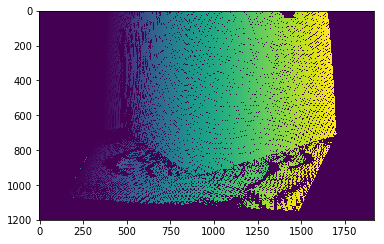

In [3]:
#
# first generate arrays containing the "true" codes projected by 
# the projector
#
# the projector had a resolution of 1280x800 so there are black bars 
# of 128 pixels on either side of our 1024 pixel region

pad = np.zeros((800,128))
hcode,vcode = np.meshgrid(range(1024),range(800))
Htrue = np.concatenate((pad,hcode,pad),axis=1)
Vtrue = np.concatenate((pad,vcode,pad),axis=1)
masktrue = np.concatenate((pad,np.ones((800,1024)),pad),axis=1)


#
# run your decoding on the projector images
#
thresh = 0.0000001  #this data is perfect so we can use a very small threshold
H,Hmask = decode('./gray/',0,thresh)
V,Vmask = decode('./gray/',20,thresh)

# compare to the known "true" code
assert((H==Htrue).all())
assert((V==Vtrue).all())
assert((Hmask==masktrue).all())
assert((Vmask==masktrue).all())

#
# Visualize results for the first scan and experiment to determine a good threshold
#
threshold = 0.02
code,mask = decode('./scan0/frame_C0_',0,threshold)
# diusplay view code and mask as images
code = np.multiply(code, mask)
plt.imshow(code)
plt.show


In [4]:
def triangulate(pts2L, camL, pts2R, camR):
    '''
    Triangulate the set of points seen at location pts2L / pts2R in the 
    corresponding pair of cameras. Return the 3D coords relative to the
    Global coord system.
    '''
    npts = pts2L.shape[1]
    
    qL = (pts2L - camL.c) / camL.f
    qL = np.vstack((qL, np.ones((1, npts))))
    
    qR = (pts2R - camR.c) / camR.f
    qR = np.vstack((qR, np.ones((1, npts))))
    
    R = camL.R.T @ camR.R
    t = camL.R.T @ (camR.t - camL.t)
    xL = np.ones(qL.shape, dtype=float)
    xR = np.ones(qR.shape, dtype=float)
    for i in range(npts):
        A = np.vstack((qL[:, i], -R @ qR[:, i])).T
        z, _, _, _ = np.linalg.lstsq(A, t, rcond=None)
        xL[:, i] = z[0] * qL[:, i]
        xR[:, i] = z[1] * qR[:, i]
    pts3L = camL.R @ xL + camL.t
    pts3R = camR.R @ xR + camR.t
    pts3 = .5 * (pts3L + pts3R)
    return pts3


def reconstruct(imprefixL,imprefixR,threshold,camL,camR):
    """
    Performing matching and triangulation of points on the surface using structured
    illumination. This function decodes the binary graycode patterns, matches 
    pixels with corresponding codes, and triangulates the result.
    
    The returned arrays include 2D and 3D coordinates of only those pixels which
    were triangulated where pts3[:,i] is the 3D coordinte produced by triangulating
    pts2L[:,i] and pts2R[:,i]

    Parameters
    ----------
    imprefixL, imprefixR : str
        Image prefixes for the coded images from the left and right camera
        
    threshold : float
        Threshold to determine if a bit is decodeable
   
    camL,camR : Camera
        Calibration info for the left and right cameras
        
    Returns
    -------
    pts2L,pts2R : 2D numpy.array (dtype=float)
        The 2D pixel coordinates of the matched pixels in the left and right
        image stored in arrays of shape 2xN
        
    pts3 : 2D numpy.array (dtype=float)
        Triangulated 3D coordinates stored in an array of shape 3xN
        
    """

    # Decode the H and V coordinates for the two views
    lHcode, lHmask = decode(imprefixL, 0, threshold)
    lVcode, lVmask = decode(imprefixL, 20, threshold)
    rHcode, rHmask = decode(imprefixR, 0, threshold)
    rVcode, rVmask = decode(imprefixR, 20, threshold)
    
    # Construct the combined 20 bit code C = H + 1024*V and mask for each view
    CL = np.add(lHcode, np.multiply(1024, lVcode))
    CR = np.add(rHcode, np.multiply(1024, rVcode))
    
    
    rMask = np.logical_and(rHmask, rVmask)
    lMask = np.logical_and(lHmask, lVmask)

    
    CL = np.where(lMask == 1, CL, np.nan)
    CR = np.where(rMask == 1, CR, np.nan)
    
    h = CL.shape[0]
    w = CL.shape[1]
    
    # Find the indices of pixels in the left and right code image that 
    # have matching codes. If there are multiple matches, just
    # choose one arbitrarily.
    
    values,matchL,matchR = np.intersect1d(CL,CR,return_indices=True)
    
    CL = CL.flatten()
    CR = CR.flatten()
    assert((CL[matchL] == CR[matchR]).all())
    
    # Let CL and CR be the flattened arrays of codes for the left and right view
    # Suppose you have computed arrays of indices matchL and matchR so that 
    # CL[matchL[i]] == CR[matchR[i]] for all i.  The code below gives one approach
    # to generating the corresponding pixel coordinates for the matched pixels.

    
    xx,yy = np.meshgrid(range(w),range(h))
    xx = np.reshape(xx,(-1,1))
    yy = np.reshape(yy,(-1,1))
    pts2R = np.concatenate((xx[matchR].T,yy[matchR].T),axis=0)
    pts2L = np.concatenate((xx[matchL].T,yy[matchL].T),axis=0)

    # Now triangulate the points
    pts3 = triangulate(pts2L, camL, pts2R, camR)
    
    
    return pts2L,pts2R,pts3

In [47]:
# Mesh cleanup parameters


# Specify limits along the x,y and z axis of a box containing the object
# we will prune out triangulated points outside these limits
boxlimits = np.array([-200,400,-200,200,-250,200])

# Specify a longest allowed edge that can appear in the mesh. Remove triangles
# from the final mesh that have edges longer than this value
trithresh = 25

pts2Ltest = pts2L
pts2Rtest = pts2R
pts3test = pts3

#
# bounding box pruning
#

remove = np.where(pts3[0,:] < boxlimits[0])[0]
remove = np.concatenate([remove, np.where(pts3[0,:] > boxlimits[1])[0]])
remove = np.concatenate([remove, np.where(pts3[1,:] < boxlimits[2])[0]])
remove = np.concatenate([remove, np.where(pts3[1,:] > boxlimits[3])[0]])
remove = np.concatenate([remove, np.where(pts3[2,:] < boxlimits[4])[0]])
remove = np.concatenate([remove, np.where(pts3[2,:] > boxlimits[5])[0]])

remove = np.unique(remove)

pts3test = np.delete(pts3test.T, remove, axis = 0).T
pts2Ltest = np.delete(pts2Ltest.T, remove, axis = 0).T
pts2Rtest = np.delete(pts2Rtest.T, remove, axis = 0).T

#
# triangulate the 2D points to get the surface mesh
#

tri = scipy.spatial.Delaunay(pts2Ltest.T)

#
# triangle pruning
#

print(tri.simplices.shape)
badTris = np.where(np.abs(tri.simplices[:,0] - tri.simplices[:,1]) > trithresh)[0]
badTris = np.concatenate([badTris, np.where(np.abs(tri.simplices[:,0] - tri.simplices[:,2]) > trithresh)[0]])
badTris = np.concatenate([badTris, np.where(np.abs(tri.simplices[:,1] - tri.simplices[:,2]) > trithresh)[0]])

print(badTris.shape)

badTris = np.unique(badTris)

print(badTris.shape)

tri.simplices = np.delete(tri.simplices.T, badTris, axis = 1).T

vertices = np.unique(tri.simplices)




#
# remove any points which are not refenced in any triangle
#
pts3test = np.where(tri.simplices[:,:][0] == np.nan, np.nan, pts3test[:,:][0])
pts2Ltest = np.where(pts3test[:,:][0] == np.nan, np.nan, pts2Ltest)
pts2Rtest = np.where(pts3test[:,:][0] == np.nan, np.nan, pts2Rtest)


(845707, 3)
(1729722,)
(832625,)


ValueError: operands could not be broadcast together with shapes (3,) () (422975,) 